### Python based viewer tool for "Probabilistic Reasoning over time", EDAP01 Artificial Intelligence
This notebook has been provided to you by Alexander Dürr, teaching assistant on the course, spring term 2021. It is based on the ideas and structure of the original Java skeleton for this assignment, provided by Elin A. Topp. Contact us (elin_anna.topp at cs.lth.se) in case you need help!

### Note: Installing and activating widgets for Jupyter Notebook
To be able to display the visualization (dashboard,animations,etc.) you have to initially install the package  if you don't have it yet

### Note: Use Jupyter Lab for programming, Jupyter Notebook for visualization (optional)
This command only enables the extension for jupyter notebook and not in jupyter lab! You can edit from the comfort of jupyter lab though and when you feel like using the widgets just go to

Menu bar > Help > Launch Classic Notebook

## Here we go... inspecting the models, option 1

### Your main job will be in the file Filters.py and in the last cell of this notebook, this is only to understand the models

In _models_, all the actually interesting stuff is located, and in _Filters_ you should write your own code. Note that the visualization (next cell on inspecting the models, option 2) assumes to have access to an object of type _Localizer_ which in turn expects the filtering / smoothing to happen in _Filters.HMM_Filters.filter(sensorR)_. This means that IF you want to make use of the visualisation in grid-view (below!) also for the actual tracking, you MUST implement the filtering in _Filters.HMM_Filter.filter(sensorR)_ (or make changes in _Localizer.Localizer.update()_)



In [ ]:
from models import *
from view_control.Localizer import Localizer

# Testing the models, e.g., for an 4x8 grid

states = StateModel( 4, 8)
loc = Localizer( states, 1)
tMat = loc.get_transition_model()
sVecs = loc.get_observation_model()
tMat.plot_T()
sVecs.plot_o_diags()
print(sVecs.get_o_reading(0))
print(sVecs.get_o_reading(None))

print(loc.update())


## Here we go again... inspecting the models, option 2

### Your implementation job will still be in the file Filters.py, this is only to understand the models AND to get a glimpse of a tracking run (but it is slow)

In _models_, all the actually interesting stuff is located, and in _Filters_ you should write your own code. Note that this visualization assumes to have access to an object of type Localizer which in turn expects the filtering / smoothing to happen in _Filters.HMM_Filters.filter()_. This means that IF you want to make use of the visualisation in grid-view also for the actual tracking, you MUST implement the filtering in Filters.HMM_Filter.filter() (or make respective changes in _Localizer.Localizer.update()_)

### Your Task 1)
#### Inspect the visualisation of the models by running the cell and experimenting with the GUI, in particular compare and explain the different versions of the sensor model (see more detailed instructions for the task and report)

In [ ]:
# In view_control.Dashboard, there is simply the handling of all the thread based visualisation provided, 
# no changes needed, but feel free...

from view_control import *

ROWS = 4
COLS = 4

# The dashboard creates a state model of the dimensions given by ROWS and COLS, sets up the respective 
# Transition and Observation models, as well as an instance of class Localizer. The Localizer calls at the 
# moment a stubb method toDo.Filters.HMMFilter.filter(sensorReading), which just sends back the original 
# probability distribution - no filtering is done. It is your task to implement something useful there.

# Non-uniform failure is the default sensor, sensor 0. Change to 1 if that is your default 
# (uniform sensor failure)
sensorType = 0
dash = Dashboard(ROWS, COLS, sensorType)
display(dash.db)


## Write your own "main" here (without the viewer)

### Your task 2)
#### Implement both Forward Filtering and Fixed-lag FB Smoothing with k = t-5 (a sequence length of 5)
#### Do evaluations (500 steps should be enough also for the bigger grids) according to the following, adapt the number of steps or the size of the grid if needed, but comment on it
#### Provide plots of the Manhattan distance over time

1)
* Forward Filtering with non-uniform sensor failure on 8x8 grid against
* Sensor output only (non-uniform sensor failure, count sensor failures to get the average frequency, but do not count those steps into the avg Manhattan distance) on 8x8 grid 


2)
* Forward Filtering with non-uniform sensor failure on 4x4 grid against
* Forward Filtering with uniform sensor failure on 4x4 grid


3)
* Forward Filtering with non-uniform sensor failure on 16x20 grid against
* Forward Filtering with uniform sensor failure on 16x20 grid


4)
* Forward Filtering with non-uniform sensor failure on 10x10 grid against
* Smoothing (fixed lag forward-backward smoothing) with k = t-5 (five steps for b) and non-uniform sensor failure on 10x10 grid

#### OBS: obviously, each pair-wise evaluation should be run based on the same true trajectory (cases 1, 2, 3) or same trajectory AND same sensor reading sequence (for case 4).

TODO: Compare these results (for forward filtering) with what you would get
without any filtering (pure guessing, or “filtering” based on the transition model and some random
initial guess only), and with using the sensor reports only (base average Manhattan distance only on
the steps when the sensor reports something, but count the “nothing” readings as a reference).

TODO: Print everything against true results

TODO: Fix none frequency bug

## 1) Forward Filtering with non-uniform sensor failure on 8x8 grid against sensor output

In [11]:
from models import *
from Filters import HMMFilter

import numpy as np
import matplotlib.pyplot as plt
import random

#Declare constants
rows = 8
cols = 8
uniformF = False
iterations = 500

In [12]:
sm  = StateModel(rows, cols)
tm = TransitionModel(sm)
om = ObservationModel_UF.ObservationModelUF(sm) if uniformF else ObservationModel_NUF.ObservationModel(sm)

trueInitialState = random.randint(0, sm.get_num_of_states() - 1)
rs = RobotSim(trueInitialState,sm) #Initialize robot in random state

probs = np.ones(sm.get_num_of_states()) / sm.get_num_of_states() #Uniform distrubution
HMM = HMMFilter(probs,tm,om,sm)

trueArray = []
sensedArray = []
estimatedArray= []
for move in range(iterations):
    trueState = rs.move_once(tm)
    sense = rs.sense_in_current_state(om)
    probs = HMM.filter(sense) # Call filter since we want forward filtering
    fPositions = probs.copy()
    for state in range(0, sm.get_num_of_states(), 4):
        fPositions[state:state+4] = sum(fPositions[state:state+4])
    
    estimatedPosition = sm.state_to_position(np.argmax(fPositions)) #Our final "guess" 
    truePosition = sm.state_to_position(trueState)
    sensePosition = sm.reading_to_position(sense) if sense != None else None
    
    sensedArray.append(sensePosition)
    estimatedArray.append(estimatedPosition)
    trueArray.append(truePosition)

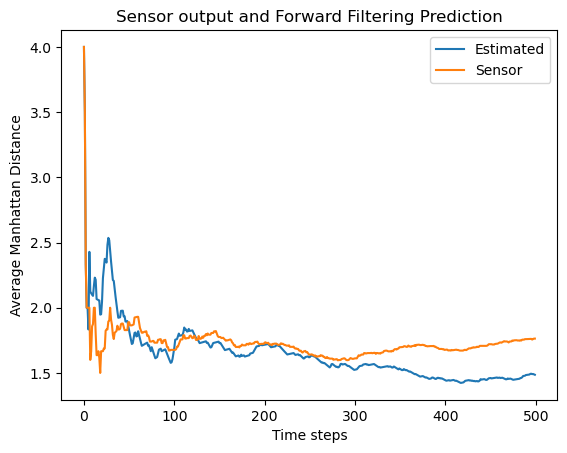

Average sensor failure: 0.324 %


In [13]:
cumulative_manhattan_distances = []
for i in range(1, len(estimatedArray) + 1):
    manhattan_distances = []
    for (sensed_point, true_point) in zip(estimatedArray[:i], trueArray[:i]):
            x1, y1 = sensed_point
            x2, y2 = true_point
            manhattan_distances.append(abs(x1 - x2) + abs(y1 - y2))
    if manhattan_distances:
        average_distance = sum(manhattan_distances) / len(manhattan_distances)
        cumulative_manhattan_distances.append(average_distance)

plt.plot(cumulative_manhattan_distances, label='Estimated')

cumulative_manhattan_distances = []
for i in range(1, len(sensedArray) + 1):
    manhattan_distances = []

    for (sensed_point, true_point) in zip(sensedArray[:i], trueArray[:i]):
        if sensed_point is not None:
            x1, y1 = sensed_point
            x2, y2 = true_point
            manhattan_distances.append(abs(x1 - x2) + abs(y1 - y2))
    if manhattan_distances:
        average_distance = sum(manhattan_distances) / len(manhattan_distances)
        cumulative_manhattan_distances.append(average_distance)

plt.plot(cumulative_manhattan_distances, label='Sensor')

# Plotting
plt.xlabel('Time steps')
plt.ylabel('Average Manhattan Distance')
plt.title('Sensor output and Forward Filtering Prediction')
plt.legend()
plt.show()

# Calculate and print the average frequency of sensor failures
average_failure_frequency = sensedArray.count(None) / len(sensedArray) # <----- CHANGED AFTER PEER REVIEW (Prev used a counter inside the for-loop)
print("Average sensor failure:", average_failure_frequency, '%')

## 2) Forward Filtering with non-uniform sensor failure on 4x4 grid against Forward Filtering with uniform sensor failure on 4x4 grid

In [ ]:
from models import *
from Filters import HMMFilter

import numpy as np
import matplotlib.pyplot as plt
import random

#Declare constants
rows = 4
cols = 4
iterations = 500

In [ ]:
sm  = StateModel(rows, cols)
tm = TransitionModel(sm)
omUF = ObservationModel_UF.ObservationModelUF(sm) 
omNUF= ObservationModel_NUF.ObservationModel(sm)

trueInitialState = random.randint(0, sm.get_num_of_states() - 1)
rs = RobotSim(trueInitialState,sm) #Initialize robot in random state

probs = np.ones(sm.get_num_of_states()) / sm.get_num_of_states() #Uniform distrubution
HMMUF = HMMFilter(probs,tm,omUF,sm)
HMMNUF = HMMFilter(probs,tm,omNUF,sm)

trueArray = []
estimatedArrayUF = []
estimatedArrayNUF = []
for move in range(iterations):
    trueState = rs.move_once(tm)
    truePosition = sm.state_to_position(trueState)
    trueArray.append(truePosition)

    senseUF = rs.sense_in_current_state(omUF)
    senseNUF = rs.sense_in_current_state(omNUF)
    
    probsUF = HMMUF.filter(senseUF) # Call filter since we want forward filtering
    probsNUF = HMMNUF.filter(senseNUF) # Call filter since we want forward filtering
    
    fPositionsUF = probsUF.copy()
    for state in range(0, sm.get_num_of_states(), 4):
        fPositionsUF[state:state+4] = sum(fPositionsUF[state:state+4])
    estimatedPositionUF = sm.state_to_position(np.argmax(fPositionsUF)) #Our final "guess" 
    estimatedArrayUF.append(estimatedPositionUF)
    
    fPositionsNUF = probsNUF.copy()
    for state in range(0, sm.get_num_of_states(), 4):
        fPositionsNUF[state:state+4] = sum(fPositionsNUF[state:state+4])
    estimatedPositionNUF = sm.state_to_position(np.argmax(fPositionsNUF)) #Our final "guess" 
    estimatedArrayNUF.append(estimatedPositionNUF)

In [ ]:
cumulative_manhattan_distances = []
for i in range(1, len(estimatedArrayUF) + 1):
    manhattan_distances = [abs(x1 - x2) + abs(y1 - y2) for (x1, y1), (x2, y2) in zip(estimatedArrayUF[:i], trueArray[:i])]
    average_distance = sum(manhattan_distances) / len(manhattan_distances)
    cumulative_manhattan_distances.append(average_distance)

# Plotting
plt.plot(cumulative_manhattan_distances, label='Uniform Failure')

cumulative_manhattan_distances = []
for i in range(1, len(estimatedArrayNUF) + 1):
    manhattan_distances = [abs(x1 - x2) + abs(y1 - y2) for (x1, y1), (x2, y2) in zip(estimatedArrayNUF[:i], trueArray[:i])]
    average_distance = sum(manhattan_distances) / len(manhattan_distances)
    cumulative_manhattan_distances.append(average_distance)

# Plotting
plt.plot(cumulative_manhattan_distances, label='Non Uniform Failure')

plt.xlabel('Time steps')
plt.ylabel('Average Manhattan Distance')
plt.title('Forward Filtering Prediction with uniform and non uniform sensor failure')
plt.legend()
plt.show()

## 3) Forward Filtering with non-uniform sensor failure on 16x20 grid against Forward Filtering with uniform sensor failure on 16x20 grid

In [ ]:
from models import *
from Filters import HMMFilter

import numpy as np
import matplotlib.pyplot as plt
import random

#Declare constants
rows = 16
cols = 20
iterations = 500

In [ ]:
sm  = StateModel(rows, cols)
tm = TransitionModel(sm)
omUF = ObservationModel_UF.ObservationModelUF(sm) 
omNUF= ObservationModel_NUF.ObservationModel(sm)

trueInitialState = random.randint(0, sm.get_num_of_states() - 1)
rs = RobotSim(trueInitialState,sm) #Initialize robot in random state

probs = np.ones(sm.get_num_of_states()) / sm.get_num_of_states() #Uniform distrubution
HMMUF = HMMFilter(probs,tm,omUF,sm)
HMMNUF = HMMFilter(probs,tm,omNUF,sm)

trueArray = []
estimatedArrayUF = []
estimatedArrayNUF = []
for move in range(iterations):
    trueState = rs.move_once(tm)
    truePosition = sm.state_to_position(trueState)
    trueArray.append(truePosition)

    senseUF = rs.sense_in_current_state(omUF)
    senseNUF = rs.sense_in_current_state(omNUF)
    
    probsUF = HMMUF.filter(senseUF) # Call filter since we want forward filtering
    probsNUF = HMMNUF.filter(senseNUF) # Call filter since we want forward filtering
    
    fPositionsUF = probsUF.copy()
    for state in range(0, sm.get_num_of_states(), 4):
        fPositionsUF[state:state+4] = sum(fPositionsUF[state:state+4])
    estimatedPositionUF = sm.state_to_position(np.argmax(fPositionsUF)) #Our final "guess" 
    estimatedArrayUF.append(estimatedPositionUF)
    
    fPositionsNUF = probsNUF.copy()
    for state in range(0, sm.get_num_of_states(), 4):
        fPositionsNUF[state:state+4] = sum(fPositionsNUF[state:state+4])
    estimatedPositionNUF = sm.state_to_position(np.argmax(fPositionsNUF)) #Our final "guess" 
    estimatedArrayNUF.append(estimatedPositionNUF)

In [ ]:
cumulative_manhattan_distances = []
for i in range(1, len(estimatedArrayUF) + 1):
    manhattan_distances = [abs(x1 - x2) + abs(y1 - y2) for (x1, y1), (x2, y2) in zip(estimatedArrayUF[:i], trueArray[:i])]
    average_distance = sum(manhattan_distances) / len(manhattan_distances)
    cumulative_manhattan_distances.append(average_distance)

# Plotting
plt.plot(cumulative_manhattan_distances, label='Uniform Failure')

cumulative_manhattan_distances = []
for i in range(1, len(estimatedArrayNUF) + 1):
    manhattan_distances = [abs(x1 - x2) + abs(y1 - y2) for (x1, y1), (x2, y2) in zip(estimatedArrayNUF[:i], trueArray[:i])]
    average_distance = sum(manhattan_distances) / len(manhattan_distances)
    cumulative_manhattan_distances.append(average_distance)

# Plotting
plt.plot(cumulative_manhattan_distances, label='Non Uniform Failure')



plt.xlabel('Time steps')
plt.ylabel('Average Manhattan Distance')
plt.title('Forward Filtering Prediction with uniform and non uniform sensor failure')
plt.legend()
plt.show()

## 4) Forward Filtering with non-uniform sensor failure on 10x10 grid against FB Smoothing with k = t-5 

In [4]:
from models import *
from Filters import HMMFilter

import numpy as np
import matplotlib.pyplot as plt
import random

#Declare constants
rows = 10
cols = 10
iterations = 500
lag = 5

In [5]:
sm  = StateModel(rows, cols)
tm = TransitionModel(sm)
om = ObservationModel_NUF.ObservationModel(sm)

trueInitialState = random.randint(0, sm.get_num_of_states() - 1)
rs = RobotSim(trueInitialState,sm) #Initialize robot in random state

probs = np.ones(sm.get_num_of_states()) / sm.get_num_of_states() #Uniform distrubution

HMMFF = HMMFilter(probs,tm,om,sm)
HMMSM = HMMFilter(probs,tm,om,sm)

trueArray = []
estimatedArrayFF = []
estimatedArraySM = []
for move in range(iterations):
    trueState = rs.move_once(tm)
    sense = rs.sense_in_current_state(om)
    truePosition = sm.state_to_position(trueState)
    trueArray.append(truePosition)
    
    fPositionsFF = HMMFF.filter(sense)
    fPositionsSM = HMMSM.smoothing(sense)
    for state in range(0, sm.get_num_of_states(), 4):
        fPositionsFF[state:state+4] = sum(fPositionsFF[state:state+4])
        fPositionsSM[state:state+4] = sum(fPositionsSM[state:state+4])
        
    estimatedPositionFF = sm.state_to_position(np.argmax(fPositionsFF)) #Our final "guess" 
    estimatedPositionSM = sm.state_to_position(np.argmax(fPositionsSM)) #Our final "guess" 
    estimatedArrayFF.append(estimatedPositionFF)
    estimatedArraySM.append(estimatedPositionSM)

#Slice the lists so they match "in time" (remove first 5 predictions from FB-Smoothing, and remove last 5 from FF and true states)
estimatedArraySM = estimatedArraySM[lag:]
estimatedArrayFF = estimatedArrayFF[:-lag]
trueArray = trueArray[:-lag]

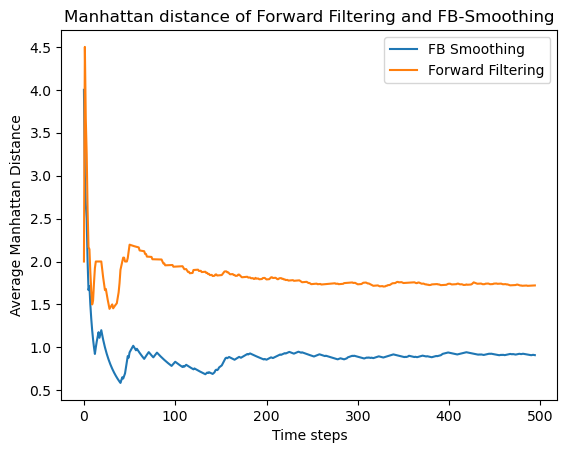

In [7]:
cumulative_manhattan_distances = []
for i in range(1, len(estimatedArraySM) + 1):
    manhattan_distances = [abs(x1 - x2) + abs(y1 - y2) for (x1, y1), (x2, y2) in zip(estimatedArraySM[:i], trueArray[:i])]
    average_distance = sum(manhattan_distances) / len(manhattan_distances)
    cumulative_manhattan_distances.append(average_distance)

# Plotting
plt.plot(cumulative_manhattan_distances, label='FB Smoothing')

cumulative_manhattan_distances = []
for i in range(1, len(estimatedArrayFF) + 1):
    manhattan_distances = [abs(x1 - x2) + abs(y1 - y2) for (x1, y1), (x2, y2) in zip(estimatedArrayFF[:i], trueArray[:i])]
    average_distance = sum(manhattan_distances) / len(manhattan_distances)
    cumulative_manhattan_distances.append(average_distance)

# Plotting
plt.plot(cumulative_manhattan_distances, label='Forward Filtering')

plt.xlabel('Time steps')
plt.ylabel('Average Manhattan Distance')
plt.title('Manhattan distance of Forward Filtering and FB-Smoothing')
plt.legend()
plt.show()